# Arctic Penguin Exploration: Unraveling Clusters in the Icy Domain with K-means clustering

You have been asked to support a team of researchers who have been collecting data about penguins in Antartica! 

**Origin of this data** : Data were collected and made available by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network.

**The dataset consists of 5 columns.**

- culmen_length_mm: culmen length (mm)
- culmen_depth_mm: culmen depth (mm)
- flipper_length_mm: flipper length (mm)
- body_mass_g: body mass (g)
- sex: penguin sex

Unfortunately, they have not been able to record the species of penguin, but they know that there are three species that are native to the region: **Adelie**, **Chinstrap**, and **Gentoo**, so your task is to apply your data science skills to help them identify groups in the dataset!

In [328]:
# Import Required Packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Loading and examining the dataset
penguins_df = pd.read_csv("data/penguins.csv")
penguins_df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE


In [329]:
penguins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


# Dataset Transformations

Checking for nulls

In [315]:
penguins_df.isna().sum()

Removing null values

In [330]:
penguins_df = penguins_df.dropna()
penguins_df.isna().sum()

culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

Checking distributions for outliers

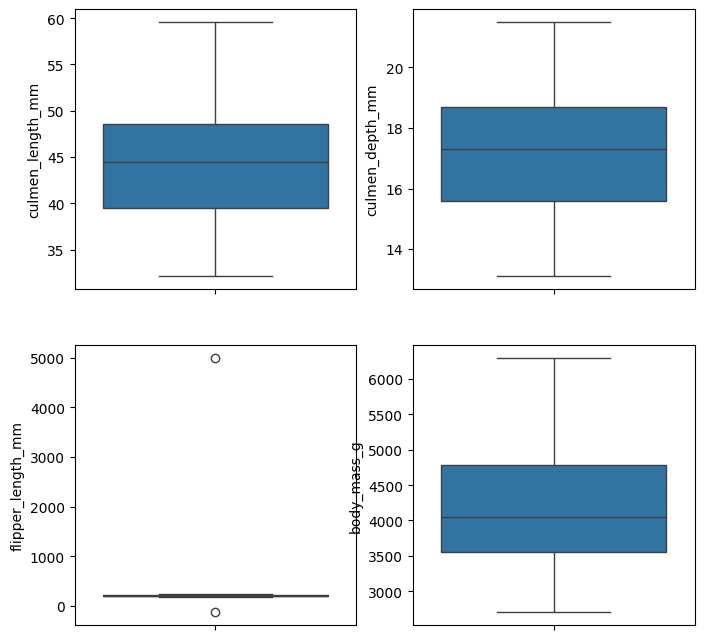

In [331]:
columns = list(penguins_df.drop('sex',axis=1).columns)
fig, axes = plt.subplots(2,2, figsize=(8,8))

for i, ax in enumerate(fig.axes):
    sns.boxplot(data=penguins_df, y=columns[i], ax=ax)
    
plt.show()

Removing outliers

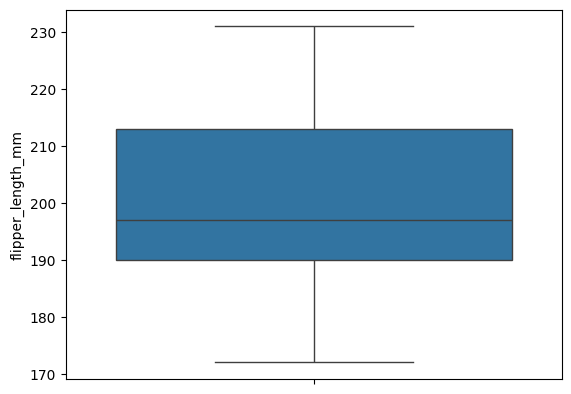

In [332]:
penguins_clean = penguins_df[(penguins_df["flipper_length_mm"] < 1000) &
                                (penguins_df["flipper_length_mm"] > 0)]
sns.boxplot(data=penguins_clean, y="flipper_length_mm")
plt.show()

In [333]:
penguins_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   333 non-null    float64
 1   culmen_depth_mm    333 non-null    float64
 2   flipper_length_mm  333 non-null    float64
 3   body_mass_g        333 non-null    float64
 4   sex                333 non-null    object 
dtypes: float64(4), object(1)
memory usage: 15.6+ KB


Removing typos

In [334]:
print(penguins_clean["sex"].value_counts())
penguins_preprocessed = penguins_clean[penguins_clean["sex"].isin(["MALE", "FEMALE"])]
print(penguins_clean["sex"].value_counts())

MALE      167
FEMALE    165
.           1
Name: sex, dtype: int64
MALE      167
FEMALE    165
Name: sex, dtype: int64


Performing standardization and one-hot encoding

In [335]:
#Scaling the numerical data
scaler = StandardScaler()
penguins_preprocessed[columns] = scaler.fit_transform(penguins_preprocessed[columns])

# Applying one hot encoding to categorical data
penguins_preprocessed = pd.get_dummies(penguins_preprocessed, prefix='', prefix_sep='')

penguins_preprocessed.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,FEMALE,MALE
0,-0.903906,0.790360,-1.425342,-0.566948,0,1
1,-0.830434,0.126187,-1.068577,-0.504847,1,0
2,-0.683490,0.432728,-0.426399,-1.187953,1,0
4,-1.344738,1.096901,-0.569105,-0.939551,1,0
5,-0.867170,1.761074,-0.783164,-0.691149,0,1


Performing PCA

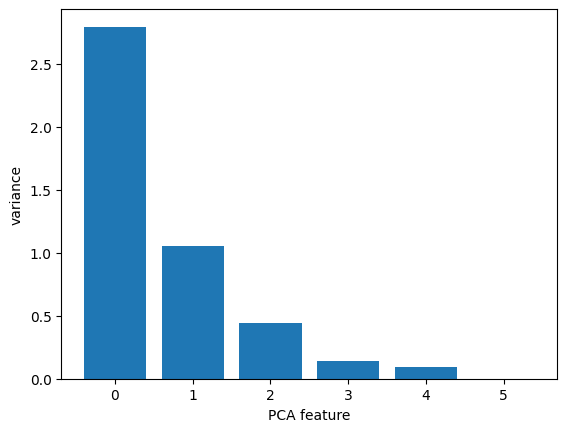

In [336]:
pca = PCA()
pca.fit(penguins_preprocessed)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

We will keep only the first two components

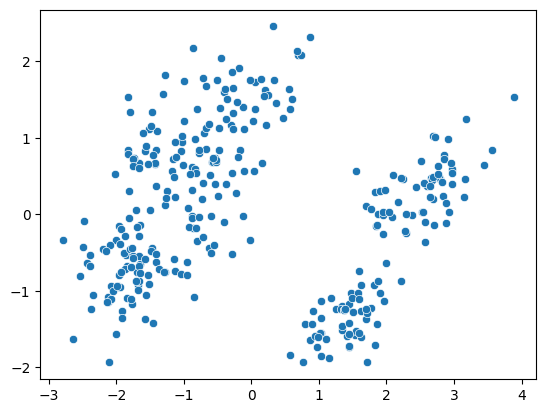

In [337]:
pca = PCA(n_components=2)
penguins_PCA = pca.fit_transform(penguins_preprocessed)
sns.scatterplot(x=penguins_PCA[:,0], y=penguins_PCA[:,1])
plt.show()

# K-means

Elbow analysis

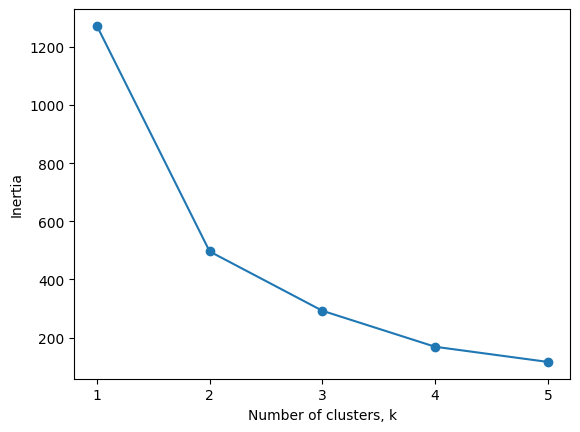

In [338]:
ks = range(1, 6)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(penguins_PCA)
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

We will use 4 clusters

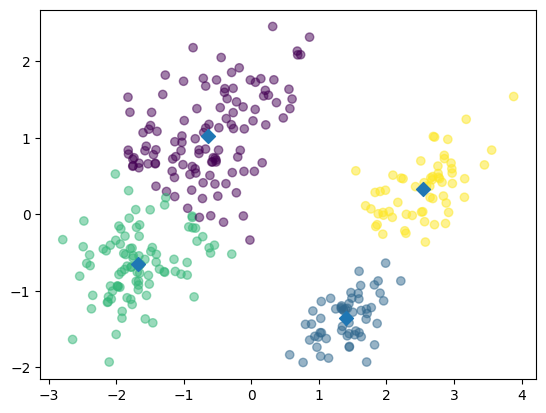

In [339]:
n_cluster = 4
kmeans = KMeans(random_state=42, n_clusters=n_cluster)
kmeans.fit(penguins_PCA)
label = kmeans.labels_

xs = penguins_PCA[:,0]
ys = penguins_PCA[:,1]
plt.scatter(xs, ys, c=label, alpha=0.5)
centroids = kmeans.cluster_centers_
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]
plt.scatter(centroids_x, centroids_y, marker='D', s=50)
plt.show()

Mean of each group

In [340]:
df_label = pd.DataFrame({"label": label})
df = pd.concat([penguins_clean, df_label], axis=1)
stat_penguins = df.groupby("label").mean()
stat_penguins

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
label,,,,
0.0,41.806087,18.056522,190.652174,3568.260870
1.0,48.050000,15.391071,216.464286,5063.392857
2.0,41.805495,18.751648,192.901099,3888.461538
3.0,47.126667,14.960000,215.583333,4938.333333
